In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from IPython import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np


In [38]:
device = torch.device("mps")

In [3]:
df = pd.read_csv('../data/30_yr_stock_market_data.csv')


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [5]:
print(df.columns.tolist())


['Dow Jones (^DJI)', 'Nasdaq (^IXIC)', 'S&P500 (^GSPC)', 'NYSE Composite (^NYA)', 'Russell 2000 (^RUT)', 'CBOE Volitility (^VIX)', 'DAX Index (^GDAXI)', 'FTSE 100 (^FTSE)', 'Hang Seng Index (^HSI)', 'Cocoa (CC=F)', 'Coffee (KC=F)', 'Corn (ZC=F)', 'Cotton (CT=F)', 'Live Cattle (LE=F)', 'Orange Juice (OJ=F)', 'Soybeans (ZS=F)', 'Sugar (SB=F)', 'Wheat (ZW=F)', 'Ethanol (EH=F)', 'Heating Oil (HO=F)', 'Natural Gas (NG=F)', 'Crude Oil-Brent (BZ=F)', 'Crude Oil-WTI (CL=F)', 'Copper (HG=F)', 'Gold (GC=F)', 'Palladium (PA=F)', 'Platinum (PL=F)', 'Silver (SI=F)', 'Treasury Yield 5 Years (^FVX)', 'Treasury Bill 13 Week (^IRX)', 'Treasury Yield 10 Years (^TNX)', 'Treasury Yield 30 Years (^TYX)']


In [140]:
dow_jones = df["Dow Jones (^DJI)"]
# Forward fill the missing values
dow_jones = dow_jones.ffill()

# Optionally, you can also backfill any remaining NaNs
dow_jones = dow_jones.bfill()


In [141]:
print(dow_jones.describe())



count     7754.000000
mean     14881.339203
std       8515.834197
min       3593.350098
25%       9474.327393
50%      11341.364746
75%      18084.122070
max      36799.648438
Name: Dow Jones (^DJI), dtype: float64


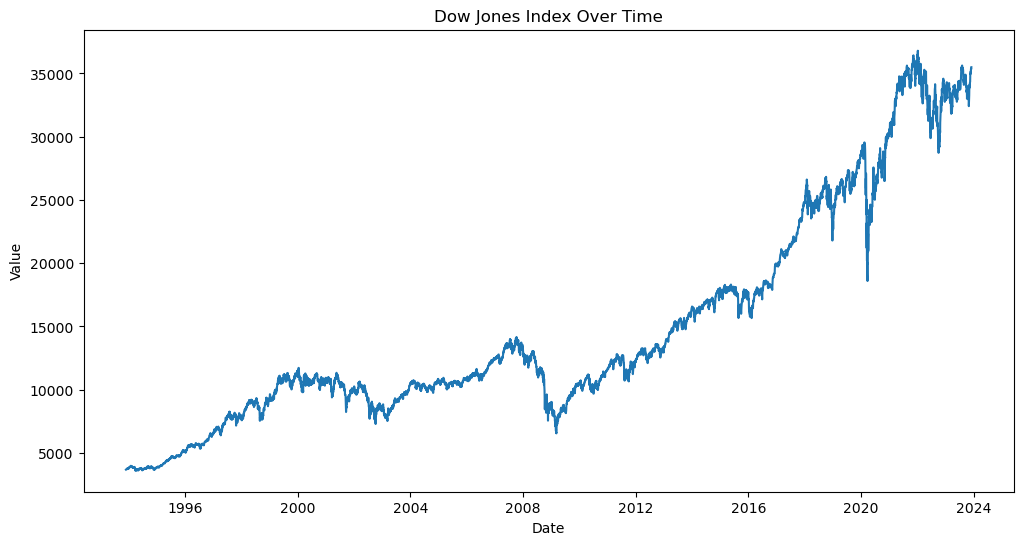

In [234]:
plt.figure(figsize=(12,6))
plt.plot(dow_jones)
plt.title('Dow Jones Index Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


In [235]:
# Reshape data for scaling
dow_jones_values = dow_jones.values.reshape(-1, 1)


In [236]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    start_values = []  # Store the first value of each sequence for inverse scaling

    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        start_value = x[0]  # First value of the sequence

        # Normalize the sequence based on the first value
        normalized_x = (x - start_value) / (start_value if start_value != 0 else 1)
        xs.append(normalized_x)
        normalized_y = (y - start_value) / (start_value if start_value != 0 else 1)
        ys.append(normalized_y)  # Keep y as the actual next value without normalization
        start_values.append(start_value)  # Store the first value for later

    return np.array(xs), np.array(ys), np.array(start_values)

def inverse_sequences(normalized_data, start_values):
    return (normalized_data * start_values[:, None]) + start_values[:, None]

seq_length = 100
# Create sequences
X, y, start_values = create_sequences(dow_jones_values, seq_length)



In [237]:
# Split the data
train_size = int(len(X) * 0.7)
validation_size = int(len(X) * 0.15)

# Split the normalized data and start values
X_train, y_train, start_values_train = X[:train_size], y[:train_size], start_values[:train_size]
X_val, y_val, start_values_val = X[train_size:train_size + validation_size], y[train_size:train_size + validation_size], start_values[train_size:train_size + validation_size]
X_test, y_test, start_values_test = X[train_size + validation_size:], y[train_size + validation_size:], start_values[train_size + validation_size:]


In [238]:
# Convert to PyTorch tensors
X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()
start_values_train = torch.tensor(start_values_train).float()
X_val, y_val = torch.tensor(X_val).float(), torch.tensor(y_val).float()
start_values_val = torch.tensor(start_values_val).float()
X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()
start_values_test = torch.tensor(start_values_test).float()




In [239]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1, layers_to_hook=None):
        super(SimpleLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size

        # Define layers
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

        # Store activations and hooks
        self.activations = {}
        self.hooks = []

        # Layers to hook
        self.layers_to_hook = layers_to_hook if layers_to_hook is not None else []

        # Automatically register hooks
        self.register_hooks()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

    def save_activation(self, name):
        def hook(model, input, output):
            if name == 'lstm':
                output_tensor = output[0]
            else:
                output_tensor = output
            self.activations[name] = output_tensor.detach().cpu().numpy().flatten()
        return hook

    def register_hooks(self):
        # Register hooks for specified layers
        for layer_name in self.layers_to_hook:
            layer = getattr(self, layer_name, None)
            if layer is not None:
                handle = layer.register_forward_hook(self.save_activation(layer_name))
                self.hooks.append(handle)

    def remove_hooks(self):
        # Remove all registered hooks
        for handle in self.hooks:
            handle.remove()
        self.hooks = []

# Example usage
activation_layers=['lstm', 'linear']
model = SimpleLSTM(layers_to_hook=activation_layers)
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [240]:
parameter_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(parameter_count)


41301


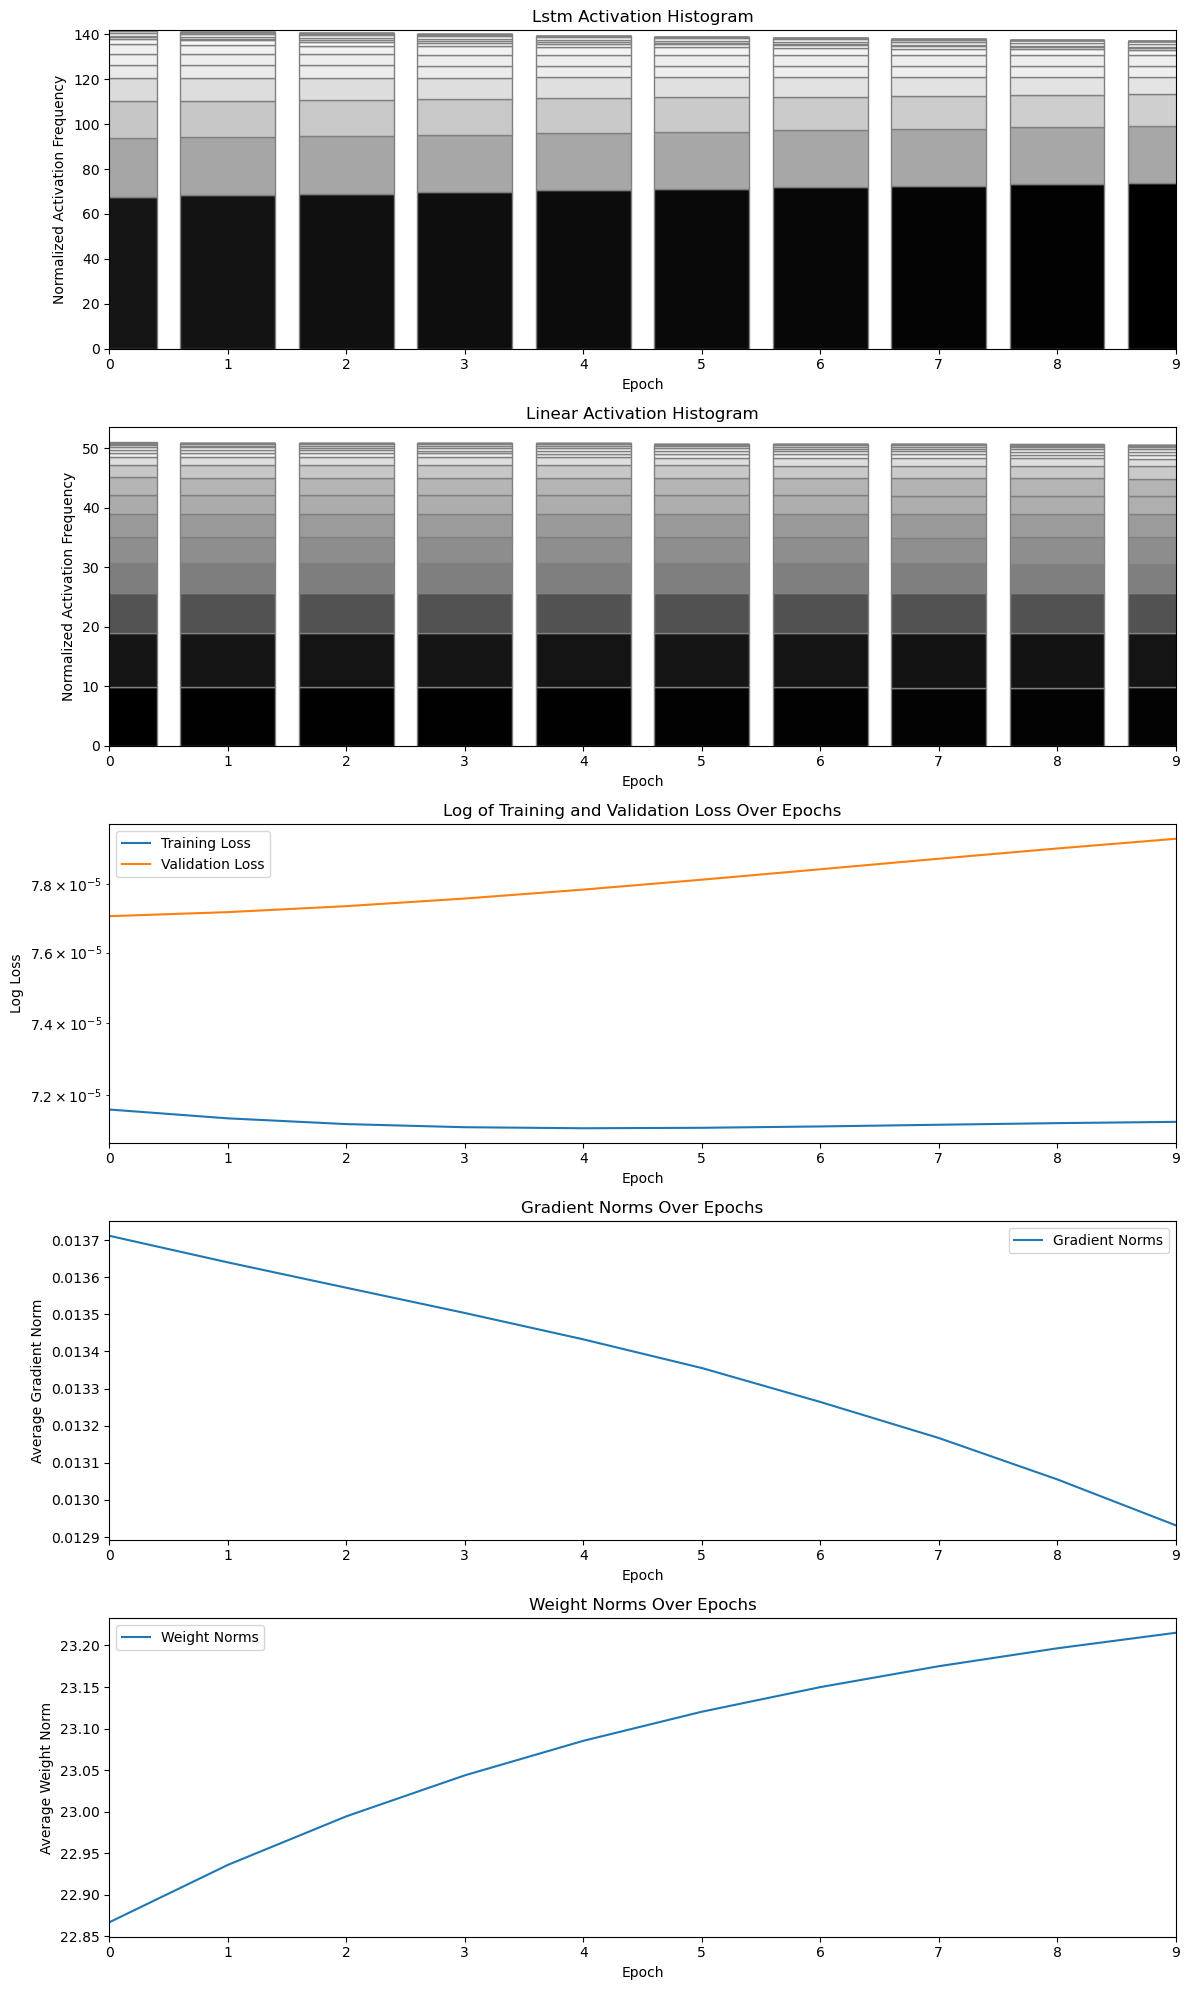

Epoch 10/10, Training Loss: 0.00007126, Validation Loss: 0.00007936


In [246]:
# Training settings
epochs = 10
batch_size = 64  # You can adjust this based on your dataset size and memory constraints

# Function to create mini-batches
def get_batches(X, y, batch_size):
    for i in range(0, len(X), batch_size):
        X_batch = X[i:i + batch_size].to(device)
        y_batch = y[i:i + batch_size].to(device)
        yield X_batch, y_batch
        

# Lists to store losses for plotting
train_losses = []
val_losses = []

# Define the number of bins for the histogram
num_bins = 20

# Initialize a data structure to store activations for each epoch
activation_histograms = {layer: [] for layer in activation_layers}

gradient_norms = []
weight_norms = []

# Training loop
for epoch in range(epochs):
    # Dictionary to store activations for the epoch, for each layer
    epoch_activations = {layer: [] for layer in activation_layers}
    epoch_gradient_norms = []
    epoch_weight_norms = []

    for X_batch, y_batch in get_batches(X_train, y_train, batch_size):
        # Move batch to device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Store activations for each layer
        for layer in activation_layers:
            activations = model.activations[layer]
            epoch_activations[layer].append(np.abs(activations))


        # Backward pass
        loss.backward()

        # Calculate and store gradient norms
        grad_norm = sum(p.grad.data.norm(2).item() for p in model.parameters() if p.grad is not None)
        epoch_gradient_norms.append(grad_norm)

        # Update weights
        optimizer.step()

        # Calculate and store weight norms
        weight_norm = sum(p.data.norm(2).item() for p in model.parameters())
        epoch_weight_norms.append(weight_norm)

    # Store the losses
    train_losses.append(loss.item())
    # Store average gradient and weight norms for the epoch
    gradient_norms.append(np.mean(epoch_gradient_norms))
    weight_norms.append(np.mean(epoch_weight_norms))
    
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val.to(device))
        val_loss = criterion(val_predictions, y_val.to(device))
    val_losses.append(val_loss.item())
    model.train()

    # Process activations to compute the histogram for the current epoch
    for layer in activation_layers:
        activations = np.hstack(epoch_activations[layer])
        counts, _ = np.histogram(activations, bins=num_bins, density=True)
        activation_histograms[layer].append(counts)

    # Clear the current figure
    display.clear_output(wait=True)

    # Plotting
    num_plots = len(activation_layers) + 3  # Additional plots for loss and norms
    fig, axs = plt.subplots(num_plots, 1, figsize=(12, 4*num_plots))

    plot_idx = 0  # Variable to keep track of the subplot index

    # Activation histogram for each layer
    for layer in activation_layers:
        hist_array = np.array(activation_histograms[layer])
        max_count = hist_array.max()

        for bin_idx in range(num_bins):
            normalized_counts = hist_array[:, bin_idx] / max_count
            colors = 1.0 - normalized_counts
            axs[plot_idx].bar(range(epoch + 1), hist_array[:, bin_idx], bottom=np.sum(hist_array[:, :bin_idx], axis=1),
                              color=[f'{c}' for c in colors], edgecolor='grey')

        axs[plot_idx].set_title(f'{layer.capitalize()} Activation Histogram')
        axs[plot_idx].set_xlabel('Epoch')
        axs[plot_idx].set_ylabel('Normalized Activation Frequency')
        axs[plot_idx].set_xlim(0, epochs - 1)

        plot_idx += 1  # Increment the subplot index


    # Loss plot with logarithmic scale
    axs[plot_idx].plot(train_losses, label='Training Loss')
    axs[plot_idx].plot(val_losses, label='Validation Loss')
    axs[plot_idx].set_title('Log of Training and Validation Loss Over Epochs')
    axs[plot_idx].set_xlabel('Epoch')
    axs[plot_idx].set_xlim(0, epochs - 1)  # Limit x-axis to the number of epochs
    axs[plot_idx].set_ylabel('Log Loss')
    axs[plot_idx].set_yscale('log')  # Set the y-axis to a logarithmic scale
    axs[plot_idx].legend()
    plot_idx+=1

    # Gradient norms plot
    axs[plot_idx].plot(gradient_norms, label='Gradient Norms')
    axs[plot_idx].set_title('Gradient Norms Over Epochs')
    axs[plot_idx].set_xlabel('Epoch')
    axs[plot_idx].set_ylabel('Average Gradient Norm')
    axs[plot_idx].set_xlim(0, epochs - 1)  # Limit x-axis to the number of epochs
    axs[plot_idx].legend()
    plot_idx+=1

    # Weight norms plot
    axs[plot_idx].plot(weight_norms, label='Weight Norms')
    axs[plot_idx].set_title('Weight Norms Over Epochs')
    axs[plot_idx].set_xlabel('Epoch')
    axs[plot_idx].set_ylabel('Average Weight Norm')
    axs[plot_idx].set_xlim(0, epochs - 1)  # Limit x-axis to the number of epochs
    axs[plot_idx].legend()

    plt.tight_layout()
    plt.show()

    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {train_losses[-1]:.8f}, Validation Loss: {val_losses[-1]:.8f}')



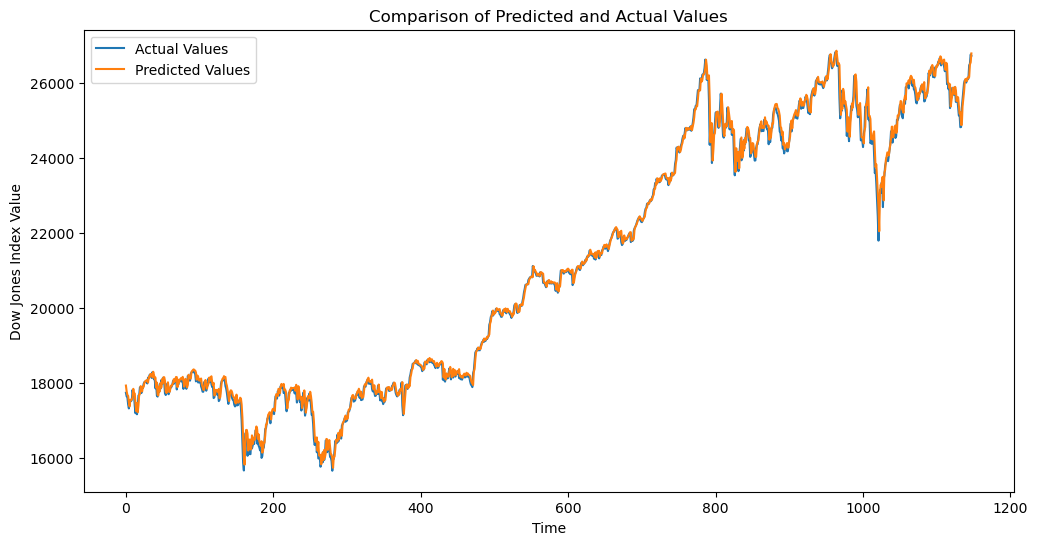

In [247]:
val_predictions_inverse = (val_predictions.cpu() * start_values_val.cpu().numpy()) + start_values_val.cpu().numpy()

# Since the actuals (y_val) are already the next value and not a sequence, we can use them directly
val_actuals = y_val.cpu().numpy()
val_actuals_inverse = (val_actuals * start_values_val.numpy()) + start_values_val.numpy()

# Plotting
plt.figure(figsize=(12,6))
# Make sure to use the flatten method to convert arrays to 1D for plotting
plt.plot(val_actuals_inverse, label='Actual Values')
plt.plot(val_predictions_inverse, label='Predicted Values')
plt.title('Comparison of Predicted and Actual Values')
plt.xlabel('Time')
plt.ylabel('Dow Jones Index Value')
plt.legend()
plt.show()

In [248]:
val_actuals_inverse[:5], val_predictions_inverse[:5]

(array([[17737.37],
        [17640.84],
        [17613.68],
        [17427.09],
        [17320.71]], dtype=float32),
 tensor([[17929.7773],
         [17772.9023],
         [17679.9199],
         [17654.7344],
         [17476.7734]]))

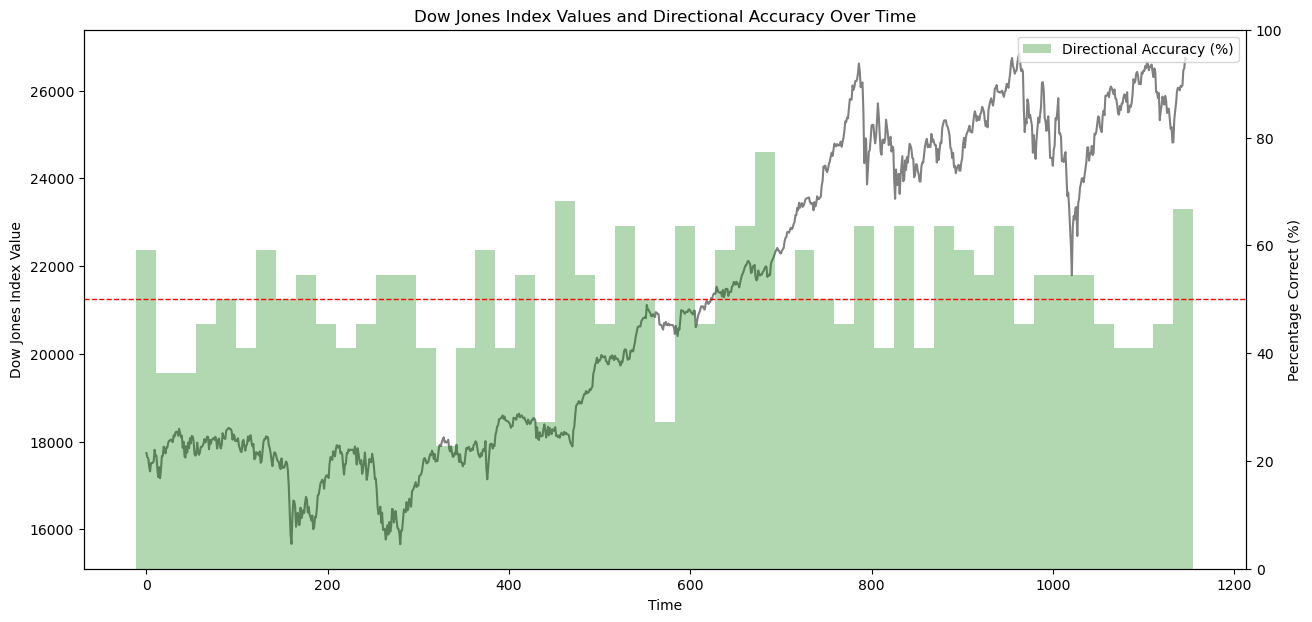

In [249]:
actual_changes = np.diff(val_actuals_inverse.flatten()) >= 0
predicted_changes = np.diff(val_predictions_inverse.flatten()) >= 0

correct_direction = actual_changes == predicted_changes

# Number of bins
num_bins = 50

# Calculate the length of each bin
bin_length = len(correct_direction) // num_bins

# Plot the actual values
plt.figure(figsize=(15, 7))
plt.plot(val_actuals_inverse.flatten(), label='Actual Values', color='gray')
plt.xlabel('Time')
plt.ylabel('Dow Jones Index Value')

# Create a secondary y-axis for percentages
ax2 = plt.twinx()

# Calculate the percentage of correct predictions for each bin
bin_percentages = []
for i in range(0, len(correct_direction), bin_length):
    bin_correct = correct_direction[i:i + bin_length]
    bin_percentage = np.sum(bin_correct) / len(bin_correct) * 100
    bin_percentages.append(bin_percentage)

# Plot the bin percentages
ax2.bar(range(0, len(correct_direction), bin_length), bin_percentages, 
        width=bin_length, alpha=0.3, color='green', label='Directional Accuracy (%)')
ax2.set_ylabel('Percentage Correct (%)')
ax2.set_ylim(0, 100)  # Set y-axis limits for percentages
ax2.axhline(50, color='red', linestyle='--', linewidth=1)

# Add legend
plt.title('Dow Jones Index Values and Directional Accuracy Over Time')
plt.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

In [250]:
model_mse = mean_squared_error(val_actuals_inverse, val_predictions_inverse)
print(f"Model Validation MSE: {model_mse:.4f}")
print(f"Directional Accuracy: {np.sum(correct_direction)/len(correct_direction) * 100:.2f}%")


Model Validation MSE: 35162.0391
Directional Accuracy: 50.31%


Rolling Mean Model Validation MSE: 369057.5854
Rolling Mean Model Directional Accuracy: 52.70%

LSTM, 10 epochs, 10 seq_len, 41301 parameters
LSTM Model Validation MSE: 433850.3750
LSTM Directional Accuracy: 52.16%

with normalisation of sequences:
LSTM, 25 epochs, 10 seq_len, 41301 parameters
LSTM Model Validation MSE: 33822.5195
LSTM Directional Accuracy: 50.00%

same but 50 epochs and 100 seq_len:
Model Validation MSE: 34161.9648
Directional Accuracy: 49.78%
after more than about 45 epochs the validation loss starts going up